In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bubblewrap as bw
import bubblewrap.input_sources.functional as fin
import tqdm as tqdm

## Define Datasets

In [4]:
datasets = {
    'a': obs,
    'b': fin.prosvd_data(obs, 30, 30),
    'c': fin.prosvd_data(obs, 3, 30),
    'd': fin.prosvd_data(obs, 1, 30),
    'e': beh,
    'f': fin.zscore(beh, 30),
    'g': fin.prosvd_data(fin.zscore(beh, 10), 1, 20),
    'h': fin.prosvd_data(np.hstack([obs[10:], fin.zscore(beh, 10)]), 5, 20),
}

keys = list(datasets.keys())

input_keys = 'b c d f g h'.split(" ")
output_keys = 'd h'.split(" ")


100%|█| 27236/27236 [00:10<00:00, 2550.06
100%|█| 27236/27236 [00:01<00:00, 17987.6
100%|█| 27236/27236 [00:01<00:00, 20864.0
100%|█| 27266/27266 [00:00<00:00, 324487.
100%|█| 27266/27266 [00:00<00:00, 347322.
100%|█| 27236/27236 [00:01<00:00, 24290.6
100%|█| 27266/27266 [00:00<00:00, 346464.
100%|█| 27236/27236 [00:01<00:00, 18719.3


In [8]:
fig, ax = plt.subplots(ncols=len(input_keys), figsize=(14,4))
for i, key in enumerate(input_keys):
    ax[i].hist(datasets[key].flatten(), bins=100, density=True)
    ax[i].set_title(key)

NameError: name 'input_keys' is not defined

In [9]:
fig, ax = plt.subplots(ncols=len(output_keys), figsize=(14,4))
for i, key in enumerate(output_keys):
    ax[i].hist(datasets[key].flatten(), bins=100, density=True)
    ax[i].set_title(key)

NameError: name 'output_keys' is not defined

## Run table

In [10]:
def evaluate(i,o, auto_reg=False):
    i, o = fin.clip(i,o)
    
    if not auto_reg:
        alpha_dict = fin.bwrap_alphas_ahead(input_arr=i, bw_params= bw.default_parameters.default_jpca_dataset_parameters, nsteps=[0,1])
    a_current, a_ahead, o = fin.clip(alpha_dict[0], alpha_dict[1], o)
    reg = bw.SymmetricNoisyRegressor(input_d=a_current.shape[1], output_d=o.shape[1], init_min_ratio=5)
    if auto_reg:
        reg = bw.regressions.AutoRegressor(input_d=a_current.shape[1], output_d=o.shape[1])
        a_current = o
        a_ahead = o
    pred = []
        
    for i, (x, y) in enumerate(list(zip(a_current, o))[:-1]):
        reg.safe_observe(x, y)
        pred.append(reg.predict(a_ahead[i]))

    pred = np.array(pred)
    if len(pred.shape) == 1:
        pred = pred.reshape(-1,1)
    
    return pred, o[1:]


In [3]:
results = {}
true_values = {}
for okey in output_keys:
    results[okey] = {}
    for ikey in input_keys:
        print(f"{okey= } {ikey= }")
        
        pred, true = evaluate(datasets[ikey], datasets[okey])
        
        results[okey][ikey] = pred
        
        if okey not in true_values:
            true_values[okey] = true

NameError: name 'output_keys' is not defined

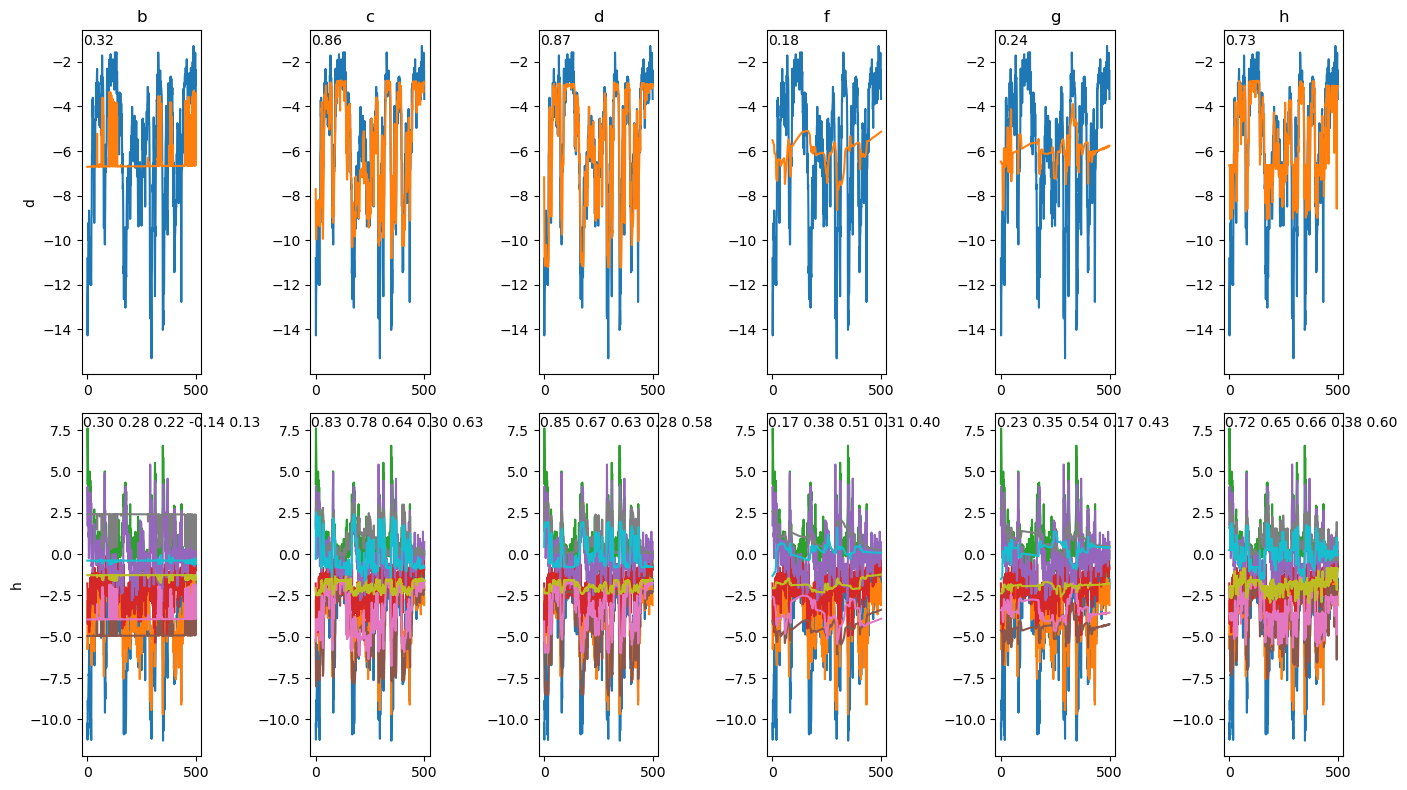

In [14]:
fig, ax = plt.subplots(nrows=len(output_keys), ncols=len(input_keys), figsize=(14,4*len(output_keys)), layout='tight')

s = slice(-1200,-700)

for row, okey in enumerate(output_keys):
    ax[row,0].set_ylabel(okey)
    for col, ikey in enumerate(input_keys):
        true, predicted = fin.clip(true_values[okey], results[okey][ikey])
        
        if 1:
            ax[row,col].plot(true[s])
            ax[row,col].plot(predicted[s])
        else:
            ax[row,col].plot(predicted[s]-true[s])
            ax[row,col].set_ylim((true.max() - true.min()) * np.array([-.5, .5]))
            # ax[row,col].plot()
        
        halfway = len(true)//2
        
        corrs = " ".join([f"{np.corrcoef(true[halfway:,j], predicted[halfway:,j])[0,1]:.2f}" for j in range(true.shape[1])])
        ax[row,col].text(.01,.99, corrs, ha='left', va='top', transform=ax[row, col].transAxes)
        if row == 0:
            ax[0,col].set_title(ikey)

#     pred = bslice[i].behavior_pred_history[1][-1000:]
#     err = np.squeeze(bslice[i].behavior_error_history[1][-1000:])
    
#     true = pred-err

#     ax[c,r].plot(true)
#     ax[c,r].plot(pred)
#     
    
#     if c == 0:
#         ax[c,r].set_title(input_keys[r])
#     if r == 0:
#         ax[c,r].set_ylabel(output_keys[c])

100%|█| 817999/817999 [00:02<00:00, 31644
100%|█| 817969/817969 [00:45<00:00, 18128
100%|█| 817979/817979 [00:35<00:00, 23160
 37%|▎| 299430/817969 [23:44<41:06, 210.2


KeyboardInterrupt: 

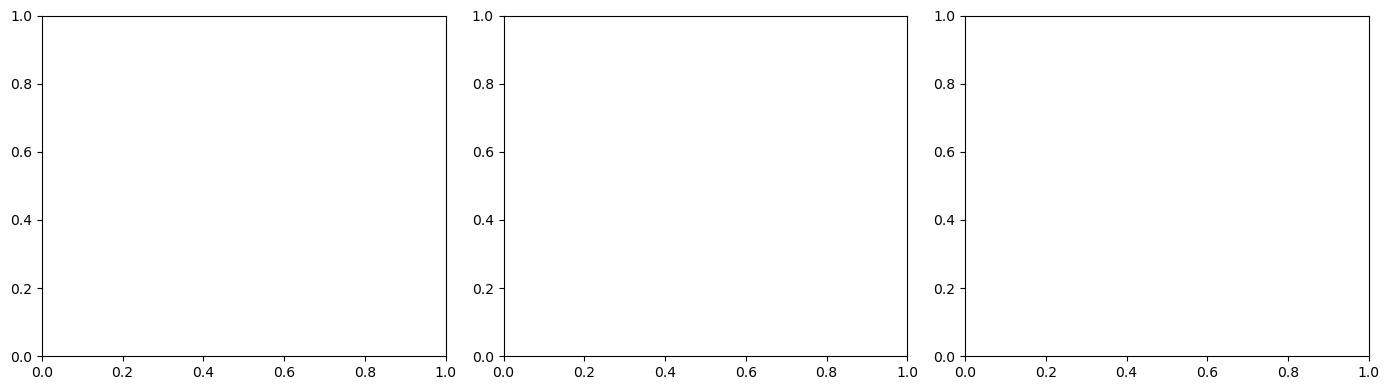

In [14]:
bin_widths = [.001, .03, .06]

fig, ax = plt.subplots(nrows=1, ncols=len(bin_widths), figsize=(14,4*1), layout='tight')

for idx, bin_width in enumerate(bin_widths):
    obs, beh, t = fin.get_indy_data(bin_width)
    i = fin.prosvd_data(np.hstack([obs[10:], fin.zscore(beh, 10)]), 5, 20)
    o = fin.prosvd_data(beh, 1, 20)
    predicted, true = evaluate(i, o)
    predicted, true, t = fin.clip(predicted, true, t)
    
    mask = (800 < t) & (t < 860)
    ax[idx].plot(t[mask], true[mask])
    ax[idx].plot(t[mask], predicted[mask])
    ax[idx].set_title(f"{bin_width = }")

100%|█| 8179999/8179999 [00:24<00:00, 331
  8%| | 641735/8179969 [00:35<06:51, 1832


KeyboardInterrupt: 

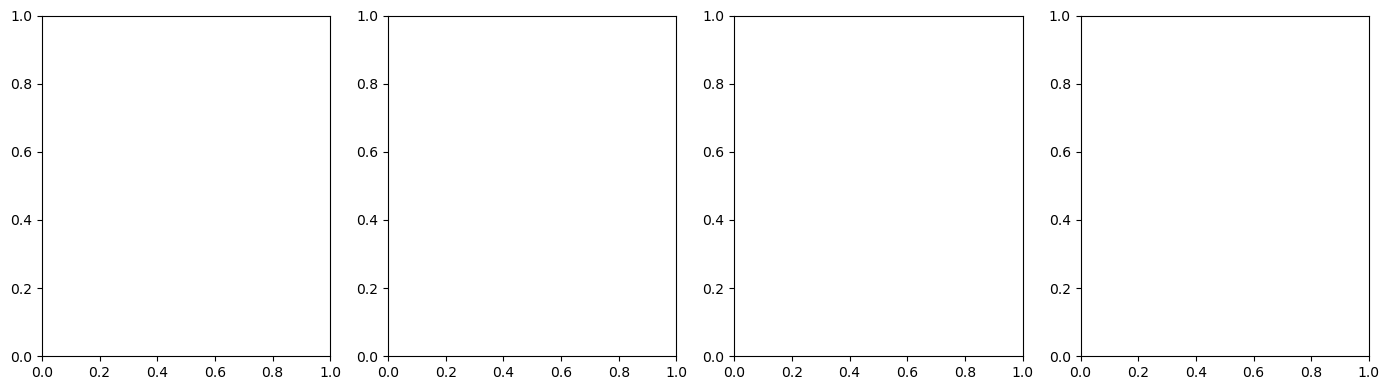

In [13]:
bin_widths = [.0001, .01, .03, .06]

fig, ax = plt.subplots(nrows=1, ncols=len(bin_widths), figsize=(14,4*1), layout='tight')

for idx, bin_width in enumerate(bin_widths):
    obs, beh, t = fin.get_indy_data(bin_width)
    i = fin.prosvd_data(np.hstack([obs[10:], fin.zscore(beh, 10)]), 5, 20)
    o = fin.prosvd_data(beh, 1, 20)
    predicted, true = evaluate(i, o, auto_reg=True)
    predicted, true, t = fin.clip(predicted, true, t)
    
    mask = (800 < t) & (t < 860)
    ax[idx].plot(t[mask], true[mask])
    ax[idx].plot(t[mask], predicted[mask])
    ax[idx].set_title(f"{bin_width = }")

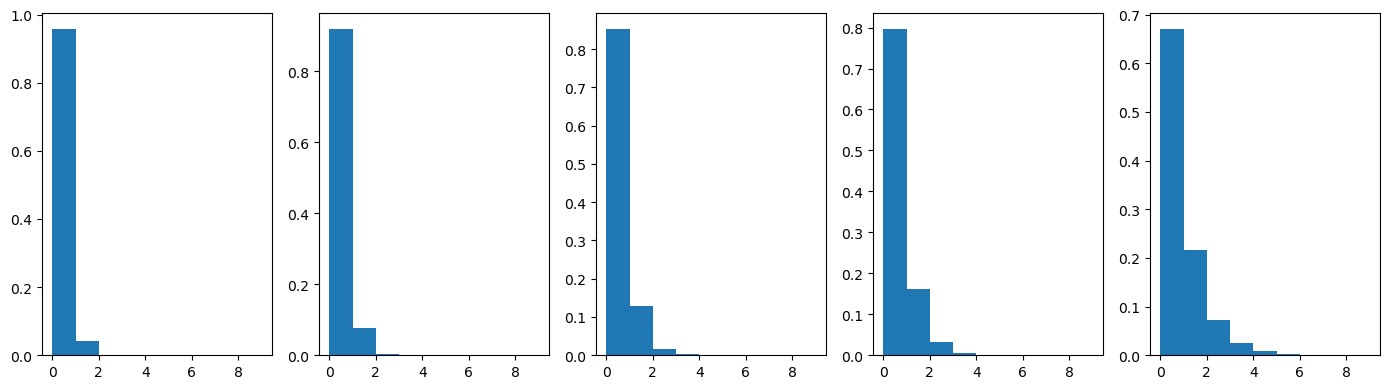

In [16]:
bin_widths = [.005, .01, .02, .03, .06]

fig, ax = plt.subplots(nrows=1, ncols=len(bin_widths), figsize=(14,4*1), layout='tight')

for idx, bin_width in enumerate(bin_widths):
    obs, beh, t = fin.get_indy_data(bin_width)
    
    ax[idx].hist(obs.flatten(), bins=np.arange(10), density=True)
    # ax[idx].imshow(obs, aspect='auto', interpolation='nearest')

In [4]:
obs, beh, t = fin.get_indy_data(bin_width)

In [7]:
t

array([ 70.05,  70.11,  70.17, ..., 887.79, 887.85, 887.91])

In [44]:
[predicted[:,int(x)] for x in [0,1]]

TypeError: list indices must be integers or slices, not tuple

In [26]:
a.shape

(40, 3)

In [13]:
def do_regression(dataset, beh, method=1, nsteps=1, num=200):
    nsteps = 1
    alphas_shift = fin.bwrap_alphas_ahead(input_arr=dataset, bw_params=dict(bw.default_parameters.default_jpca_dataset_parameters, num=num), nsteps=nsteps)
    alphas_curr = fin.bwrap_alphas_ahead(input_arr=dataset, bw_params=dict(bw.default_parameters.default_jpca_dataset_parameters, num=num), nsteps=0)

    method = ['predicted current step', 'current step'][method]


    cut_beh = beh[-len(alphas_curr):]

    reg = bw.regressions.SymmetricNoisyRegressor(input_d=alphas_curr.shape[1], output_d=1)
    # reg = bw.regressions.NearestNeighborRegressor(input_d=alphas_curr.shape[1], output_d=1)
    preds = []
    cb = []
    for i in tqdm.tqdm(range(nsteps, len(alphas_curr)-2)):
        if method == 'predicted current step':
            reg.safe_observe(alphas_shift[i-nsteps], cut_beh[i])
        elif method == 'current step':
            reg.safe_observe(alphas_curr[i], cut_beh[i])


        preds.append(reg.predict(alphas_shift[i]))
        cb.append(cut_beh[i+nsteps])


    preds = np.squeeze(preds[np.nonzero(np.isfinite(preds))[0][0]:])[-1000:]
    cb = np.squeeze(cb)[-1000:]
    return preds, cb

100%|█| 2197/2197 [00:00<00:00, 4810.88i


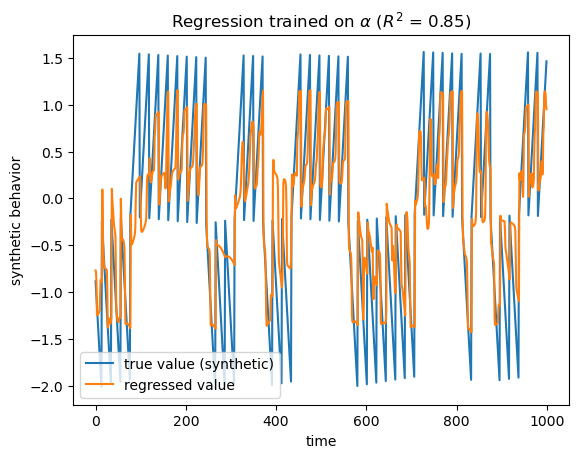

In [31]:
%matplotlib inline
fig, ax = plt.subplots()

p, t = do_regression(datasets['s3(z([s(neural), behavior]))'], datasets['z(behavior)'], method=1, num=60)

ax.plot(t)
ax.plot(p);
ax.set_xlabel('time')
ax.set_ylabel('synthetic behavior')
ax.set_title(f"Regression trained on $\\alpha$ ($R^2$ = {np.corrcoef(p,t)[0,1]:.2f})")
ax.legend(['true value (synthetic)', 'regressed value']);

100%|█| 2197/2197 [00:00<00:00, 3064.88i


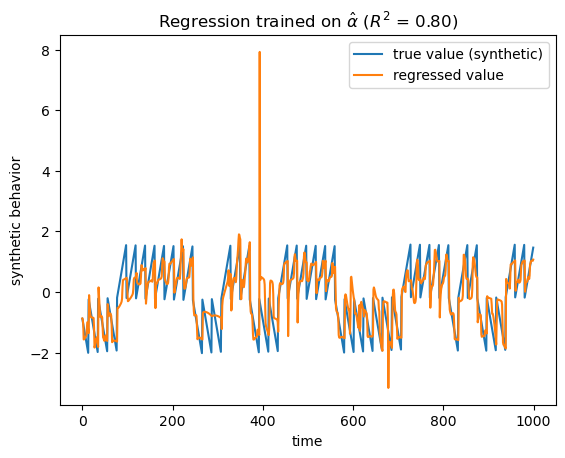

In [32]:
%matplotlib inline
fig, ax = plt.subplots()

p, t = do_regression(datasets['s3(z([s(neural), behavior]))'], datasets['z(behavior)'], method=0, num=60)

ax.plot(t)
ax.plot(p);
ax.set_xlabel('time')
ax.set_ylabel('synthetic behavior')
ax.set_title(f"Regression trained on $\\hat\\alpha$ ($R^2$ = {np.corrcoef(p,t)[0,1]:.2f})")
ax.legend(['true value (synthetic)', 'regressed value']);

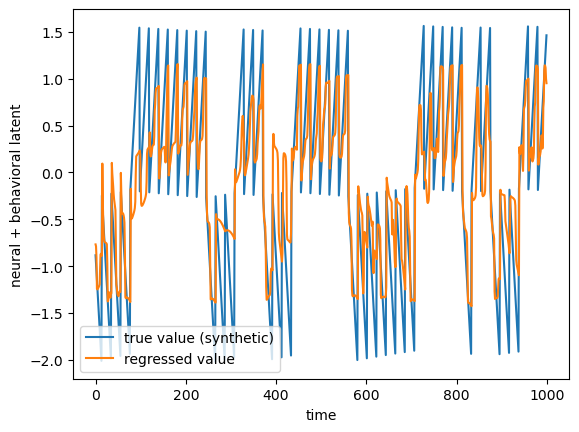

In [30]:
%matplotlib inline
fig, ax = plt.subplots()

ax.plot(t)
ax.plot(p);
ax.set_xlabel('time')
ax.set_ylabel('neural + behavioral latent')
ax.legend(['true value (synthetic)', 'regressed value']);

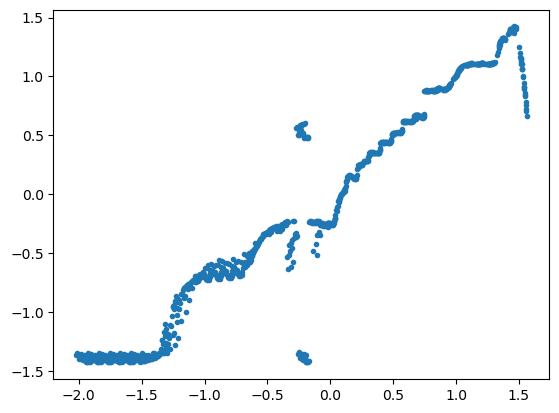

In [31]:
%matplotlib inline
fig, ax = plt.subplots()

# ax.plot(t)
ax.plot(t,p, '.');

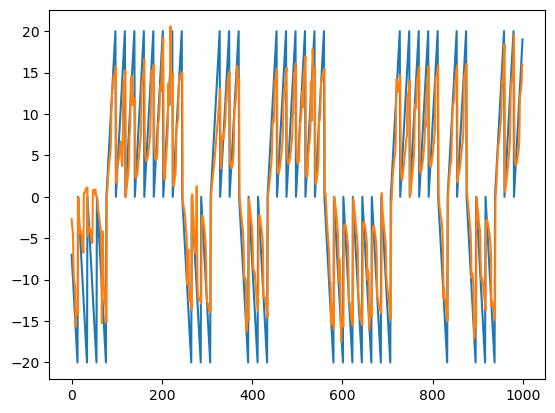

In [28]:
%matplotlib inline
fig, ax = plt.subplots()

ax.plot(cb)
ax.plot(preds);

In [33]:
plt.imshow(alphas_curr, aspect='auto', interpolation='nearest')

NameError: name 'alphas_curr' is not defined

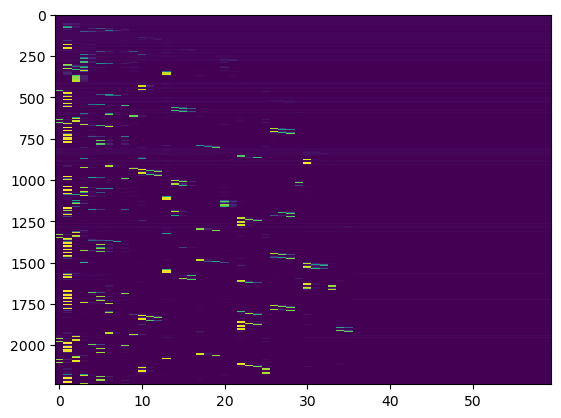

In [6]:
plt.imshow(alphas_shift, aspect='auto', interpolation='nearest')

0.00462546

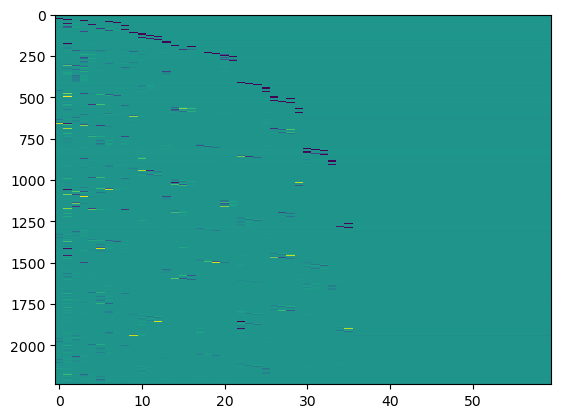

In [7]:
shift = 1
diff = alphas_shift[:-shift] - alphas_curr[shift:]
plt.imshow(diff, aspect='auto', interpolation='nearest')
(diff**2).mean()

In [32]:
plt.hist(diff[abs(diff) > .02].flatten(), bins=200, log=True);

NameError: name 'diff' is not defined

In [26]:
concatenated = fin.zscore(np.hstack([obs, beh]))
datasets = {
    'z(s(neural))': fin.zscore(obs),
    'z(behavior)': fin.zscore(beh),
    'z([s(neural), behavior])': concatenated,
    's3(z([s(neural), behavior]))': fin.prosvd_data(concatenated, 3, 30),
    's1(z([s(neural), behavior]))': fin.prosvd_data(concatenated, 1, 30),
    's1(z(s(neural)))': fin.prosvd_data(fin.zscore(obs), 1, 30),
    'z(behavior)': fin.zscore(beh),
}

keys = list(datasets.keys())

100%|█| 27599/27599 [00:00<00:00, 115814
100%|█| 27599/27599 [00:00<00:00, 250121
100%|█| 27599/27599 [00:00<00:00, 341258
100%|█| 27563/27563 [00:01<00:00, 17400.
100%|█| 27563/27563 [00:01<00:00, 16986.
100%|█| 27599/27599 [00:00<00:00, 245706
100%|█| 27563/27563 [00:01<00:00, 23591.
100%|█| 27599/27599 [00:00<00:00, 343892
